In [40]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\user\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import statsmodels.api as sm

In [42]:
df = pd.read_csv('health.csv')
df.columns = ['date','click']
df

,date,click
0,2019-01-01,36
1,2019-01-02,45
2,2019-01-03,41
3,2019-01-04,40
4,2019-01-05,40
...,...,...
360,2019-12-27,86
361,2019-12-28,80
362,2019-12-29,87
363,2019-12-30,88


### 시계열 데이터의 조건
- 1년 이상 수집(계절성 반영)
- 일정한 간격으로 빠짐없이 데이터가 수집되어야 함
- 선형성 전제 [선형성, 독립성, 등분산성, 정규성]

In [43]:
df['click'].isnull().sum()

0

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    365 non-null    object
 1   click   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [45]:
# date가 시계열인지 확인
type(df['date'][0])

str

In [46]:
df['date'] = pd.to_datetime(df['date'])
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [47]:
#시간 : timedelta, 간격
#시각 : timestamp, 점
df['date'][1] - df['date'][0]

Timedelta('1 days 00:00:00')

<AxesSubplot: xlabel='date'>

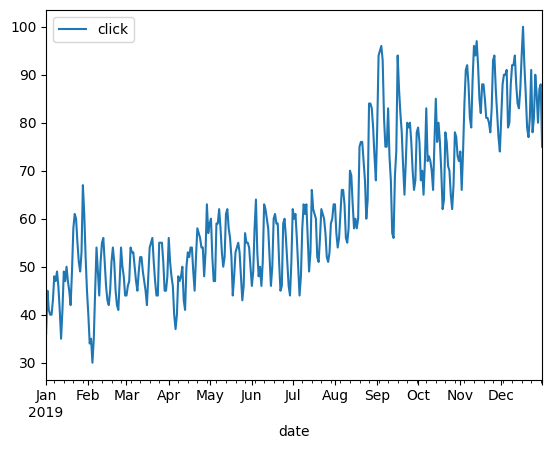

In [48]:
# 시계열 회귀
df.plot(x='date',y='click')

In [49]:
x = range(len(df['date'])) # 독립변수는 timestamp를 인식하지 못함 -> range로 바꿔주어 숫자로 치환
y = df['click']

x = sm.add_constant(x)  # y절편 뽑아내기
model = sm.OLS(y, x)    # 일반회귀분석 : mse    # 정규성 위배될 때에는 다른 모델 사용
result = model.fit()
print(result.params)

const    39.057534
x1        0.126554
dtype: float64


In [50]:
type(result.params)

pandas.core.series.Series

In [51]:
a = result.params[0]    # y절편
b = result.params[1]    # 기울기

In [56]:
# 일반항
df1 = df.copy()
df1.date = range(len(df1))
df1.prediction = df1.date.apply(lambda x : b*x+a)
df1

,date,click,prediction
0,0,36,364.000000
1,1,45,364.126554
2,2,41,364.253109
3,3,40,364.379663
4,4,40,364.506217
...,...,...,...
360,360,86,409.559536
361,361,80,409.686091
362,362,87,409.812645
363,363,88,409.939199


In [53]:
# 일반항
df['prediction'] = [b*x+a for x in range(len(df['date']))]
df

# pred = []
# for i in x:
#     pred.append(b*i+a)
# df['prediction'] = pred
# df

,date,click,prediction
0,2019-01-01,36,39.057534
1,2019-01-02,45,39.184089
2,2019-01-03,41,39.310643
3,2019-01-04,40,39.437197
4,2019-01-05,40,39.563751
...,...,...,...
360,2019-12-27,86,84.617071
361,2019-12-28,80,84.743625
362,2019-12-29,87,84.870179
363,2019-12-30,88,84.996733


<AxesSubplot: xlabel='date'>

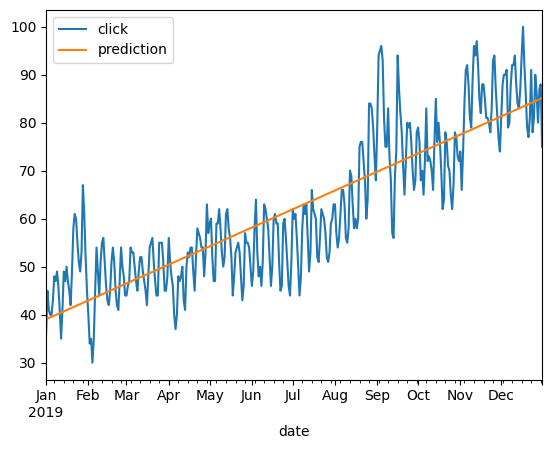

In [64]:
df.plot(x='date',y=['click','prediction'])

In [57]:
# 추세만 고려
mse=[]
for a, i in enumerate(df['click']):
    mse.append((i-df['prediction'][a])**2)
np.mean(mse)

64.7166329373385

In [66]:
# 2 = 화요일
yo = [2,3,4,5,6,0,1]
season = []
for i in range(len(df['click'])//len(yo)):
    for w in yo:
        season.append(w)
season.append(2)    # 남는 요일의 수 추가 -> 7*52 = 354이기 때문에 yo의 0번째 인덱스 추가
len(season)

365

In [67]:
df['season'] = season
df

,date,click,prediction,season
0,2019-01-01,36,39.057534,2
1,2019-01-02,45,39.184089,3
2,2019-01-03,41,39.310643,4
3,2019-01-04,40,39.437197,5
4,2019-01-05,40,39.563751,6
...,...,...,...,...
360,2019-12-27,86,84.617071,5
361,2019-12-28,80,84.743625,6
362,2019-12-29,87,84.870179,0
363,2019-12-30,88,84.996733,1


In [71]:
df['trend'] = df.index
x = df[['season', 'trend']] 
y = df['click']

x = sm.add_constant(x)  
model = sm.OLS(y, x)   
result = model.fit()
print(result.params)

const     42.960569
season    -1.291633
trend      0.126380
dtype: float64


<AxesSubplot: xlabel='date'>

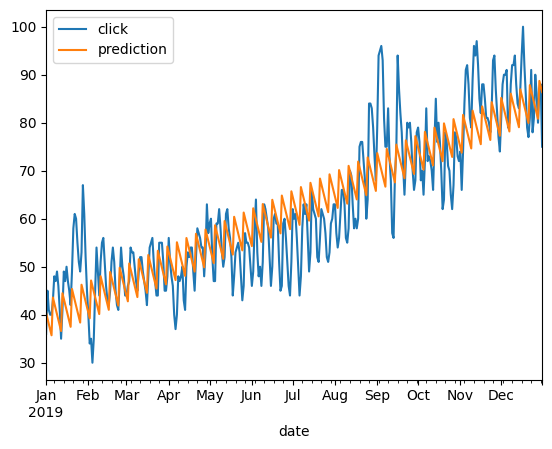

In [75]:
a = result.params[0]    # y절편
b1 = result.params[1]    # 기울기
b2 = result.params[2]

df['prediction'] = [b1*x+b2+a for x in range(len(df['date']))]
pred = []
for i in range(len(df['date'])):
    pred.append(b1*df['season'][i]+b2*df['trend'][i]+a)
df['prediction'] = pred

df.plot(x='date',y=['click','prediction'])

In [76]:
# 추세와 주기를 고려
mse=[]
for a, i in enumerate(df['click']):
    mse.append((i-df['prediction'][a])**2)
np.mean(mse)

58.05742898051807

-회귀 -> 다항 회귀 : 추세정보 + 주기정보 -> 시간 외에 다른 변수가 작용할 때 사용

-시계열은 하나의 특성만 고려 가능 -> 다른 독립변수가 들어올 자리가 없음 -> 변수가 시간일때만 사용

-강의 유무를 오늘 데이터를 넣고 학습을 시키고 다음 예측하게 시키고 계속 주기적으로 반복해주면 학습하지 않을까?

-내일을 예측하려면 내일의 강의 유무를 넣어줘야 함, 추가해주려면 새로운 지수를 만들어야 함

In [87]:
df = pd.read_csv('LGSS.csv')
df
# 기간이 1년 미만이라 시계열 분석 어려움

,Date,LG,Samsung
0,2019-01-01,23,60
1,2019-01-02,31,73
2,2019-01-03,31,70
3,2019-01-04,23,75
4,2019-01-05,24,64
...,...,...,...
146,2019-05-27,26,90
147,2019-05-28,31,86
148,2019-05-29,28,83
149,2019-05-30,24,72


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     151 non-null    object
 1   LG       151 non-null    int64 
 2   Samsung  151 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ KB


In [89]:
type(df['Date'][0])

str

<AxesSubplot: xlabel='Date'>

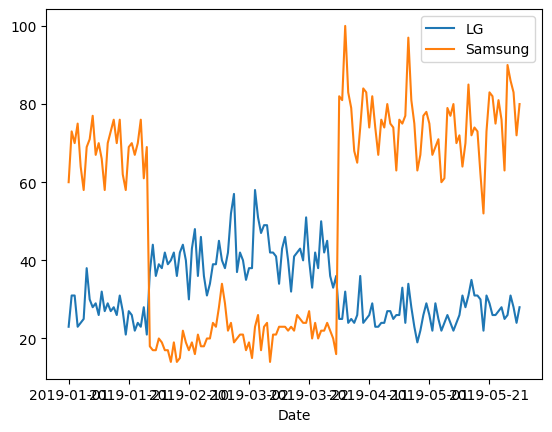

In [90]:
df.plot(x='Date',y=['LG',"Samsung"])

In [95]:
x = range(len(df['Date']))
y = df['Samsung']

x = sm.add_constant(x)  
model = sm.OLS(y, x)   
result = model.fit()
print(result.params)

const    32.974904
x1        0.243778
dtype: float64


In [96]:
a = result.params[0]    
b = result.params[1]

pred = []
for i in range(len(df['Date'])):
    pred.append(b*i+a)
df['prediction'] = pred
df

,Date,LG,Samsung,prediction
0,2019-01-01,23,60,32.974904
1,2019-01-02,31,73,33.218682
2,2019-01-03,31,70,33.462461
3,2019-01-04,23,75,33.706239
4,2019-01-05,24,64,33.950017
...,...,...,...,...
146,2019-05-27,26,90,68.566539
147,2019-05-28,31,86,68.810317
148,2019-05-29,28,83,69.054096
149,2019-05-30,24,72,69.297874


<AxesSubplot: xlabel='Date'>

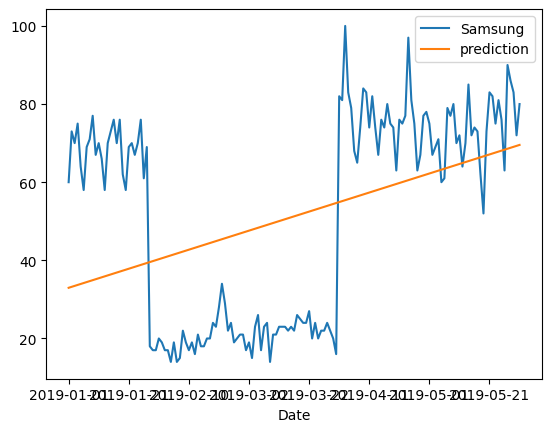

In [97]:
df.plot(x='Date', y=['Samsung', 'prediction'])

In [105]:
# 언제 변화가 있었는지 확인
df[50:100]  #27~90 인덱스 기준으로 낮아지고 올라감

,Date,LG,Samsung,prediction
50,2019-02-20,45,28,45.163820
51,2019-02-21,40,34,45.407598
52,2019-02-22,38,29,45.651377
53,2019-02-23,42,22,45.895155
54,2019-02-24,52,24,46.138933
55,2019-02-25,57,19,46.382712
56,2019-02-26,37,20,46.626490
57,2019-02-27,42,21,46.870268
58,2019-02-28,40,21,47.114047
59,2019-03-01,35,17,47.357825


In [107]:
before = df.iloc[:27]
after = df.iloc[90:]
left = df.iloc[27:90]

In [108]:
right = pd.concat([before,after], axis=0)
right

,Date,LG,Samsung,prediction
0,2019-01-01,23,60,32.974904
1,2019-01-02,31,73,33.218682
2,2019-01-03,31,70,33.462461
3,2019-01-04,23,75,33.706239
4,2019-01-05,24,64,33.950017
...,...,...,...,...
146,2019-05-27,26,90,68.566539
147,2019-05-28,31,86,68.810317
148,2019-05-29,28,83,69.054096
149,2019-05-30,24,72,69.297874


In [109]:
x = right.index
y = right.Samsung

x = sm.add_constant(x)  
model = sm.OLS(y, x)   
result = model.fit()
print(result.params)

const    68.427246
x1        0.052718
dtype: float64


In [110]:
a = result.params[0]    
b = result.params[1]

pred = []
for i in right.index:
    pred.append(b*i+a)
right['prediction'] = pred
right

,Date,LG,Samsung,prediction
0,2019-01-01,23,60,68.427246
1,2019-01-02,31,73,68.479964
2,2019-01-03,31,70,68.532683
3,2019-01-04,23,75,68.585401
4,2019-01-05,24,64,68.638119
...,...,...,...,...
146,2019-05-27,26,90,76.124123
147,2019-05-28,31,86,76.176841
148,2019-05-29,28,83,76.229560
149,2019-05-30,24,72,76.282278


In [111]:
x = left.index
y = left.Samsung

x = sm.add_constant(x)  
model = sm.OLS(y, x)   
result = model.fit()
print(result.params)

const    16.149098
x1        0.081173
dtype: float64


In [112]:
a = result.params[0]    
b = result.params[1]

pred = []
for i in left.index:
    pred.append(b*i+a)
left['prediction'] = pred
left

C:\Users\user\AppData\Local\Temp\ipykernel_23648\1317301895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['prediction'] = pred


,Date,LG,Samsung,prediction
27,2019-01-28,37,18,18.340774
28,2019-01-29,44,17,18.421947
29,2019-01-30,36,17,18.503120
30,2019-01-31,39,20,18.584293
31,2019-02-01,38,19,18.665467
...,...,...,...,...
85,2019-03-27,42,22,23.048819
86,2019-03-28,45,24,23.129992
87,2019-03-29,36,22,23.211166
88,2019-03-30,33,20,23.292339


In [113]:
df2 = pd.concat([right.iloc[:27], left, right.iloc[27:]], axis=0)
df2

,Date,LG,Samsung,prediction
0,2019-01-01,23,60,68.427246
1,2019-01-02,31,73,68.479964
2,2019-01-03,31,70,68.532683
3,2019-01-04,23,75,68.585401
4,2019-01-05,24,64,68.638119
...,...,...,...,...
146,2019-05-27,26,90,76.124123
147,2019-05-28,31,86,76.176841
148,2019-05-29,28,83,76.229560
149,2019-05-30,24,72,76.282278


<AxesSubplot: xlabel='Date'>

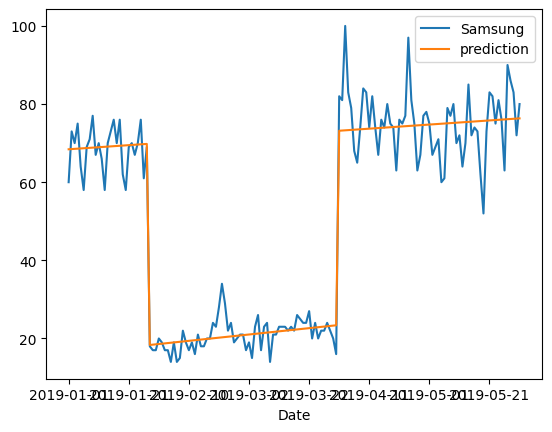

In [114]:
df2.plot(x='Date', y=['Samsung', 'prediction'])

In [ ]:
y = b1*x + b2*m + b3*m*x + a
m = 조절항

In X 
y절편 = 68.4
기울기 = 0.05

In O
y절편 = 16.1
기울기 = 0.08

b1 = 0.05
b2 = -52.3 = y절편 변화량
b3 = 0.03 = 기울기 변화량
a = 68.4

Samsung 검색량의 약 80%의 검색량을 LG가 가져옴

검색에 할애하는 시간이 정해져 있다 -> LG 검색량이 많아지니 삼성의 검색량이 상대적으로 떨어진다

기울기 차이와 cos을 통해 각도를 구할 수 있음

In [122]:
df = pd.read_csv('LGSS.csv')
df

,Date,LG,Samsung
0,2019-01-01,23,60
1,2019-01-02,31,73
2,2019-01-03,31,70
3,2019-01-04,23,75
4,2019-01-05,24,64
...,...,...,...
146,2019-05-27,26,90
147,2019-05-28,31,86
148,2019-05-29,28,83
149,2019-05-30,24,72


In [123]:
moderator=[]
for i in range(27):
    moderator.append(0)
for i in range(90-27):
    moderator.append(1)
for i in range(151-90):
    moderator.append(0)

len(moderator)

151

In [124]:
df['interruption'] = moderator
df

,Date,LG,Samsung,interruption
0,2019-01-01,23,60,0
1,2019-01-02,31,73,0
2,2019-01-03,31,70,0
3,2019-01-04,23,75,0
4,2019-01-05,24,64,0
...,...,...,...,...
146,2019-05-27,26,90,0
147,2019-05-28,31,86,0
148,2019-05-29,28,83,0
149,2019-05-30,24,72,0


In [131]:
df['trend'] = df.index
df['interaction'] = df['trend'] * df['interruption']
df

,Date,LG,Samsung,interruption,interaction,trend
0,2019-01-01,23,60,0,0,0
1,2019-01-02,31,73,0,0,1
2,2019-01-03,31,70,0,0,2
3,2019-01-04,23,75,0,0,3
4,2019-01-05,24,64,0,0,4
...,...,...,...,...,...,...
146,2019-05-27,26,90,0,0,146
147,2019-05-28,31,86,0,0,147
148,2019-05-29,28,83,0,0,148
149,2019-05-30,24,72,0,0,149


In [132]:
# y = b1*x + b2*m + b3*m*x + a
#        b1         b2              b3
x = df[['trend','interruption','interaction']]
y = df.Samsung

x = sm.add_constant(x)  
model = sm.OLS(y, x)   
result = model.fit()
print(result.params)

const           68.427246
trend            0.052718
interruption   -52.278149
interaction      0.028455
dtype: float64


In [133]:
a = result.params[0]    # y절편
b1 = result.params[1]   # 기울기
b2 = result.params[2]   # 조절항
b3 = result.params[3]   # 상호작용항

pred = []
for i in df.index:
    pred.append(b1*df['trend'][i]+b2*df['interruption'][i] + b3*df['interaction'][i] + a)
df['prediction'] = pred
df

,Date,LG,Samsung,interruption,interaction,trend,prediction
0,2019-01-01,23,60,0,0,0,68.427246
1,2019-01-02,31,73,0,0,1,68.479964
2,2019-01-03,31,70,0,0,2,68.532683
3,2019-01-04,23,75,0,0,3,68.585401
4,2019-01-05,24,64,0,0,4,68.638119
...,...,...,...,...,...,...,...
146,2019-05-27,26,90,0,0,146,76.124123
147,2019-05-28,31,86,0,0,147,76.176841
148,2019-05-29,28,83,0,0,148,76.229560
149,2019-05-30,24,72,0,0,149,76.282278


<AxesSubplot: xlabel='Date'>

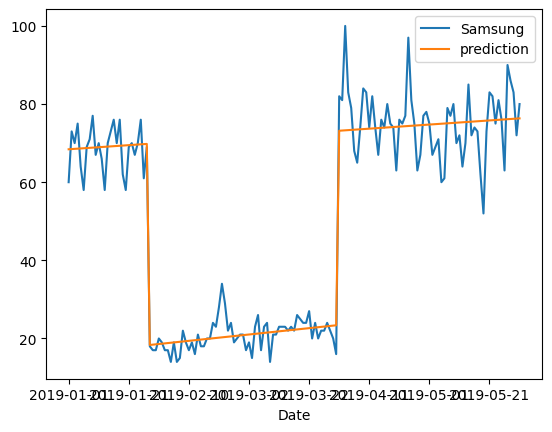

In [135]:
df.plot(x='Date',y=['Samsung','prediction'])